In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pycasso import fitsQ3DataCube
from scipy import constants as c
from scipy.optimize import minimize

# Modelando linhas de emissão

Vamos modelar as linhas de emissão utilizando gaussianas. A função gauss ajusta 3 gaussianas somadas!

In [2]:
def gauss(p, x):
    A1, mu1, sigma1 = p
    return A1 * np.exp(-(x - mu1) ** 2 / (2. * sigma1 ** 2))

def N2Ha_gauss_profile(p, x):
    A1, mu1, sigma1, A2, mu2, sigma2, A3, mu3, sigma3 = p
    g1 = gauss((A1, mu1, sigma1), x)
    g2 = gauss((A2, mu2, sigma2), x)
    g3 = gauss((A3, mu3, sigma3), x)
    return g1 + g2 + g3

def adjust_N2Ha(l_obs, f_res, constrains, x0, bounds):
    to_min = lambda p: np.square(f_res - N2Ha_gauss_profile(p, l_obs)).sum()
    adj = minimize(to_min, x0=x0, constraints=cons, method='SLSQP', bounds=bounds, options=dict(ftol=1e-8, eps=1e-5))
    return adj

# import pyneb as pn
# N2 = pn.Atom('N', 2)
# N2.plotGrotrian()

adjust_N2Ha vai ajustar as duas linhas de [NII] ao redor de Halpha e Halpha também. Claro que a função ajustaria qualquer 3 gaussianas somadas usando gauss(), as constrains, o x0 (chute inicial) e bounds. 
Se você tiver o pyneb instalado é legal fazer pyneb.Atom('N', 2).plotGrotrian() que aparecem os níveis de energia e as linhas produzidas.

In [3]:
# load CALIFA 10 PyCASSO Voronoi SN20 cube
K = fitsQ3DataCube('K0010_synthesis_eBR_v20_q054.d22a512.ps03.k1.mE.CCM.Bgstf6e.fits')

O arquivo K0XXX_synthesis_eBR_v20_q054.d22a512.ps03.k1.mE.CCM.Bgstf6e é o que chamamos de superfits no CALIFA e já é um cubo pronto pra ser usado no PyCASSO. Os superfits já possuem a síntese com o STARLIGHT e o espectro observado é uma união do espectro da V1200 com o da V500 e recriado na resolução do pior (acho que é 6 AA, mas amostrado de 2 em 2AA). A galáxia foi previamente zonificada usando tesselagem Voronoi com SN 20 (v20) com a versão 0.54 do qbick (q054 - qbick guarda os mapas de segmentação da galáxia, máscara das estrelas que estão na frente da galáxia, máscara dos badpixels e mapas spaxel<->zones). 'd22a512.ps03.k1.mE' tem a ver com a pipeline de redução, creio, mas nunca mexi com nada disso. CCM é óbvio, a lei de extinção que foi usada e, por último, Bgstf6e é a base de Granada+MILES na qual a síntese com o STARLIGHT foi feita. Vou imprimir aqui as idades e metalicidades:

In [4]:
K.ageBase

array([  1.00000000e+06,   3.00000000e+06,   3.98110000e+06,
         5.62300000e+06,   8.91300000e+06,   1.00000000e+07,
         1.25900000e+07,   1.41300000e+07,   1.77800000e+07,
         1.99500000e+07,   2.51190000e+07,   3.16200000e+07,
         3.98110000e+07,   5.62300000e+07,   6.00000000e+07,
         7.00000000e+07,   1.00000000e+08,   1.50000000e+08,
         2.00000000e+08,   3.00000000e+08,   3.50000000e+08,
         5.00000000e+08,   7.00000000e+08,   9.00000000e+08,
         1.00000000e+09,   1.25000000e+09,   1.50000000e+09,
         2.00000000e+09,   2.50000000e+09,   3.50000000e+09,
         4.50000000e+09,   6.50000000e+09,   8.00000000e+09,
         1.00000000e+10,   1.10000000e+10,   1.25000000e+10,
         1.40000000e+10])

In [5]:
K.metBase

array([ 0.0001 ,  0.00031,  0.00103,  0.00418,  0.00846,  0.02181,
        0.03425,  0.04741])

Bem, vamos começar o ajuste das linhas utilizando gaussianas. 
Primeiro um exemplo utilizando o espectro do núcleo: fluxo observado, sintético e residual no intervalo de comprimento de onda de interesse:

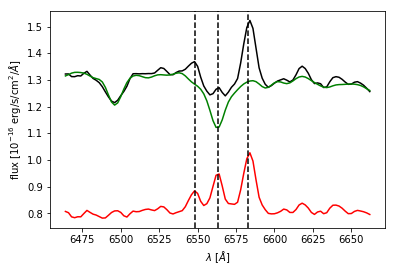

In [6]:
N2Ha_window = np.bitwise_and(np.greater(K.l_obs, 6563-100), np.less(K.l_obs, 6563+100))
i_nuc = 0
l_obs = K.l_obs[N2Ha_window]
f_obs_nuc__l = K.f_obs[N2Ha_window, i_nuc] * 1e16
f_syn_nuc__l = K.f_syn[N2Ha_window, i_nuc] * 1e16
f_res_nuc__l = f_obs_nuc__l - f_syn_nuc__l
plt.plot(l_obs, f_obs_nuc__l, 'k-', l_obs, f_syn_nuc__l, 'g-', l_obs, 0.8+f_res_nuc__l, 'r-')
plt.xlabel(r'$\lambda\ [\AA]$')
plt.ylabel(r'flux [$10^{-16}$ erg/s/cm${}^2/\AA$]')
plt.axvline(x=6548, c='k', ls='--')
plt.axvline(x=6563, c='k', ls='--')
plt.axvline(x=6583, c='k', ls='--')

Vamos agora definir os chutes iniciais para os parametros que serão ajustados (x0), os limites (bounds) e as restrições (cons). Os constrains são que as linhas de [NII] devem ter mesmo sigma e velocidade além da linha mais azul ter 3 vezes o fluxo da linha mais vermelha. Como estamos fixando os sigmas, podemos fixar as amplitudes ao invés do fluxo (pois $F = A \sigma \sqrt{2\pi}$).

In [7]:
x0 = [1., 6548, 2.6, 1., 6563, 2.6, 3., 6583, 2.6]
bounds = [
    [0,100], [6548-10, 6548+10], [2.6, 8],
    [0,100], [6563-10, 6563+10], [2.6, 8],
    [0,100], [6583-10, 6583+10], [2.6, 8],
]
cons = (
    {'type': 'eq', 'fun' : lambda x: np.array((x[d_x0i['lambda1']] - 6548.)/6548. - (x[d_x0i['lambda3']] - 6583.)/6583.)},
    {'type': 'eq', 'fun' : lambda x: np.array(x[d_x0i['sigma1']]/x[d_x0i['lambda1']] - x[d_x0i['sigma3']]/x[d_x0i['lambda3']])},
    {'type': 'eq', 'fun' : lambda x: np.array(x[d_x0i['sigma2']]/x[d_x0i['lambda2']] - x[d_x0i['sigma3']]/x[d_x0i['lambda3']])},
    {'type': 'eq', 'fun' : lambda x: np.array(3*x[d_x0i['A1']] - x[d_x0i['A3']])}
)
d_x0i = {
    'A1':0, 'lambda1':1, 'sigma1':2,
    'A2':3, 'lambda2':4, 'sigma2':5,
    'A3':6, 'lambda3':7, 'sigma3':8,
}

Aqui então temos um loop passando por todas as zonas ajustando as linhas. Eu fiz uma pequena modificação no loop que usando um pseudo-contínuo para reduzir problemas no "contínuo" do resíduo. Nesse loop já salvo os vetores com os parâmtros ajustados.

In [8]:
minimize__z = []
ampl__Lz = {'6548':np.zeros((K.N_zone)), '6563':np.zeros((K.N_zone)), '6583':np.zeros((K.N_zone))}
pos__Lz = {'6548':np.zeros((K.N_zone)), '6563':np.zeros((K.N_zone)), '6583':np.zeros((K.N_zone))}
sigma__Lz = {'6548':np.zeros((K.N_zone)), '6563':np.zeros((K.N_zone)), '6583':np.zeros((K.N_zone))}
contin = []
for z in xrange(K.N_zone):
    l_obs = K.l_obs[N2Ha_window]
    f_res = K.f_obs[N2Ha_window, z] - K.f_syn[N2Ha_window, z]
    f_res *= 1e16
    # subtract pseudo-continuum
    blue_window = np.bitwise_and(np.greater(l_obs, 6525), np.less(l_obs, 6540))
    red_window = np.bitwise_and(np.greater(l_obs, 6591), np.less(l_obs, 6606))
    x = np.array([6525 + (6540 - 6525)/2., 6591 + (6606 - 6591)/2.])
    y = np.array([np.median(f_res[blue_window]), np.median(f_res[red_window])])
    p = np.polyfit(x, y, 1)
    contin.append(p)
    f_res = f_res - np.polyval(p, l_obs)
    # ADJUST FINALLY :P
    result = adjust_N2Ha(l_obs, f_res, cons, x0, bounds)
    ampl__Lz['6548'][z] = result.x[d_x0i['A1']]
    pos__Lz['6548'][z] = result.x[d_x0i['lambda1']]
    sigma__Lz['6548'][z] = result.x[d_x0i['sigma1']]
    ampl__Lz['6563'][z] = result.x[d_x0i['A2']]
    pos__Lz['6563'][z] = result.x[d_x0i['lambda2']]
    sigma__Lz['6563'][z] = result.x[d_x0i['sigma2']]
    ampl__Lz['6583'][z] = result.x[d_x0i['A3']]
    pos__Lz['6583'][z] = result.x[d_x0i['lambda3']]
    sigma__Lz['6583'][z] = result.x[d_x0i['sigma3']]
    minimize__z.append(result)

In [9]:
speed_of_light = c.c*1e-3 # km/s
# gas velocity in km/s
v0_Ha__z = speed_of_light*(pos__Lz['6563'] - 6563)/6563.
# gas velocity dispersion in km/s
vd_Ha__z = speed_of_light*(sigma__Lz['6563'])/pos__Lz['6563']
# integrated fluxes in erg/s/cm^2 
F_Ha__z = (np.pi*2)**0.5 * sigma__Lz['6563'] * ampl__Lz['6563']*1e-16
F_N2red__z = (np.pi*2)**0.5 * sigma__Lz['6583'] * ampl__Lz['6583']*1e-16
# F_N2blue__z = F_N2red__z/3.
F_N2blue__z = (np.pi*2)**0.5 * sigma__Lz['6548'] * ampl__Lz['6548']*1e-16  

# Histogramas de $v_{H\alpha}$, $\sigma_{H\alpha}$, $\log F_{H\alpha}$ e $\log F_{[NII]}$

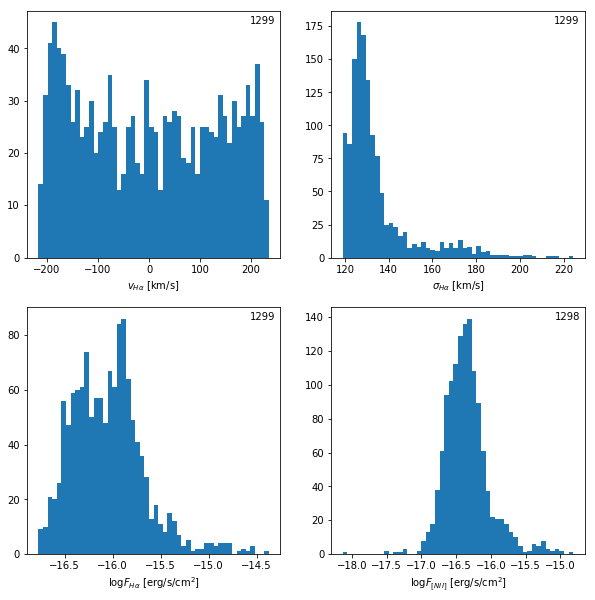

In [10]:
f, axArr = plt.subplots(2, 2, figsize=(10,10))
((ax1, ax2), (ax3, ax4)) = axArr
axList = [ax1, ax2, ax3, ax4]
mv0_Ha__z = np.ma.masked_array(v0_Ha__z, mask=np.isnan(v0_Ha__z), copy=True)
mvd_Ha__z = np.ma.masked_array(vd_Ha__z, mask=np.isnan(vd_Ha__z), copy=True)
mlogF_Ha__z = np.ma.log10(F_Ha__z)
mlogF_N2red__z = np.ma.log10(F_N2red__z)
masked_dataset = [mv0_Ha__z, mvd_Ha__z, mlogF_Ha__z, mlogF_N2red__z]
labels = [r'$v_{H\alpha}$ [km/s]', 
          r'$\sigma_{H\alpha}$ [km/s]', 
          r'$\log F_{H\alpha}$ [erg/s/cm${}^2$]', 
          r'$\log F_{[NII]}$ [erg/s/cm${}^2$]'
]
for i, ax in enumerate(axList):
    x = masked_dataset[i]
    ax.hist(x.compressed(), bins=50, histtype='stepfilled', range=[x.min(), x.max()])
    ax.set_xlabel(labels[i])
    ax.text(0.98, 0.98, '%d'%x.count(), fontsize=10, color='k',
                transform=ax.transAxes,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(alpha=0.))

Dentro do PyCASSO temos várias funcionalidades bem como os mapas de segmentação (como escrevi anteriormente). Vou usar um método criado dentro do objeto fitsQ3DataCube que é o zoneToYX() no qual posso mapear um array que tem dimensão de N_zone para uma matrix com dimensão (N_Y, N_X) que já vem com a máscara da galáxia (estrelas removidas, bad_spaxels, etc). Com esse método vou criar os mapas de v0 e vd para a linha de Halpha.

# MAPAS

# Velocidade de $H\alpha$ ($v_{H\alpha}$) e velocidade estelar ($v_\star$)

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


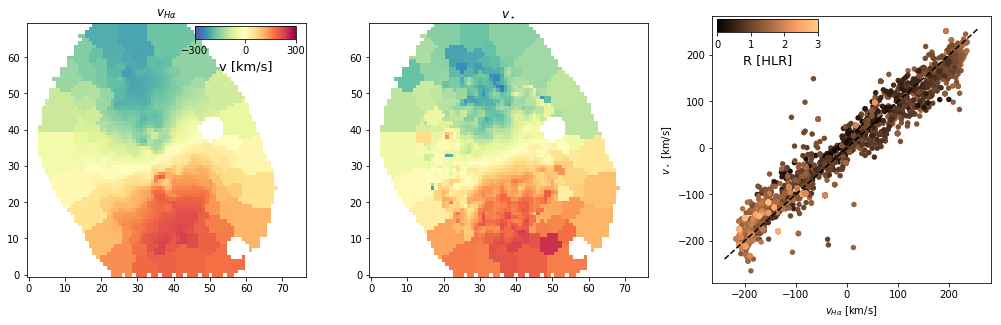

In [11]:
# V0_Ha__map:
v0_Ha__yx = K.zoneToYX(v0_Ha__z, extensive=False)
f, axArr = plt.subplots(1, 3, figsize=(14,4.5))
maps = [v0_Ha__yx, K.v_0__yx]
labels = [r'$v_{H\alpha}$', r'$v_\star$']
for i, ax in enumerate(axArr[:2]):
    ax.set_title(labels[i])
    im = ax.imshow(maps[i], origin='lower', cmap='Spectral_r', vmax=300, vmin=-300)
cbaxes = f.add_axes([0.197, 0.89, 0.10, 0.04])
cb = plt.colorbar(im, cax=cbaxes, ticks=[-300, 0, 300], orientation='horizontal')
cb.set_label(r'v [km/s]', fontsize=13) #, labelpad=-30)
x, y = v0_Ha__yx, K.v_0__yx
sel_pix_mask = np.ma.getmaskarray(x) & np.ma.getmaskarray(y)
xm = np.ma.masked_array(x, mask=sel_pix_mask)
ym = np.ma.masked_array(y, mask=sel_pix_mask)
zm = np.ma.masked_array(K.pixelDistance__yx/K.pixelsPerHLR, mask=sel_pix_mask)
ax = axArr[2]
sc = ax.scatter(xm.compressed(), ym.compressed(), vmin=0, vmax=3, c=zm.compressed(), cmap=plt.cm.copper, marker='o', s=30, edgecolor='none')
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
ax.set_xlabel(r'%s [km/s]' % labels[0])
ax.set_ylabel(r'%s [km/s]' % labels[1])
cbaxes = f.add_axes([0.715, 0.91, 0.10, 0.04])
cb = plt.colorbar(sc, cax=cbaxes, ticks=[0, 1, 2, 3], orientation='horizontal')
cb.set_label(r'R [HLR]', fontsize=13) #, color='w', labelpad=-30)
f.tight_layout()


# Dispersão da velocidade de $H\alpha$ ($\sigma_{H\alpha}$) e da velocidade estelar ($\sigma_\star$)

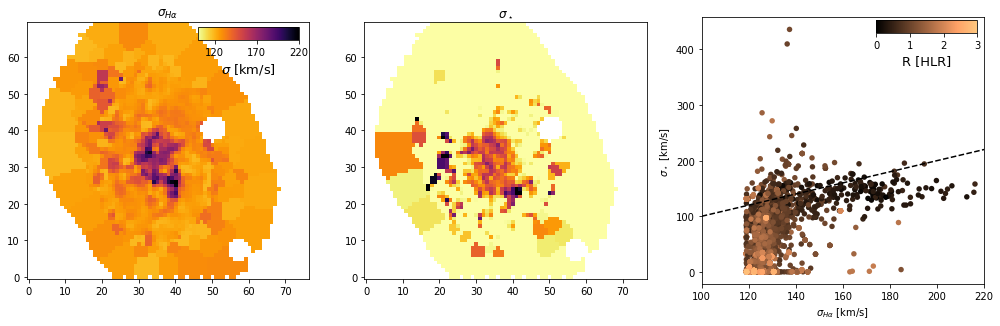

In [12]:
#vd_Ha__yx = K.zoneToYX(vd_Ha__z, extensive=False)
#im = plt.imshow(vd_Ha__yx, origin='lower', cmap='inferno_r', vmax=220, vmin=100)
#cb = plt.colorbar(im)
#cb.ax.set_ylabel(r'$\sigma_{H\alpha}$ [km/s]')

# Vd_Ha__map:
vd_Ha__yx = K.zoneToYX(vd_Ha__z, extensive=False)
f, axArr = plt.subplots(1, 3, figsize=(14,4.5))
maps = [vd_Ha__yx, K.v_d__yx]
labels = [r'$\sigma_{H\alpha}$', r'$\sigma_\star$']
for i, ax in enumerate(axArr[:2]):
    ax.set_title(labels[i])
    im = ax.imshow(maps[i], origin='lower', cmap='inferno_r', vmax=220, vmin=100)
cbaxes = f.add_axes([0.2, 0.89, 0.10, 0.04])
cb = plt.colorbar(im, cax=cbaxes, ticks=[120, 170, 220], orientation='horizontal')
cb.set_label(r'$\sigma$ [km/s]', fontsize=13) #, color='w', labelpad=-30)
x, y = vd_Ha__yx, K.v_d__yx
sel_pix_mask = np.ma.getmaskarray(x) & np.ma.getmaskarray(y)
xm = np.ma.masked_array(x, mask=sel_pix_mask)
ym = np.ma.masked_array(y, mask=sel_pix_mask)
zm = np.ma.masked_array(K.pixelDistance__yx/K.pixelsPerHLR, mask=sel_pix_mask)
ax = axArr[2]
sc = ax.scatter(xm.compressed(), ym.compressed(), vmin=0, vmax=3, c=zm.compressed(), cmap=plt.cm.copper, marker='o', s=30, edgecolor='none')
ax.set_xlim(100, 220)
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
ax.set_xlabel(r'%s [km/s]' % labels[0])
ax.set_ylabel(r'%s [km/s]' % labels[1])
cbaxes = f.add_axes([0.873, 0.91, 0.10, 0.04])
cb = plt.colorbar(sc, cax=cbaxes, ticks=[0, 1, 2, 3], orientation='horizontal')
cb.set_label(r'R [HLR]', fontsize=13) #, color='w', labelpad=-30)
f.tight_layout()

# $A_V^\star$

/usr/local/lib/python2.7/site-packages/matplotlib/colors.py:858: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


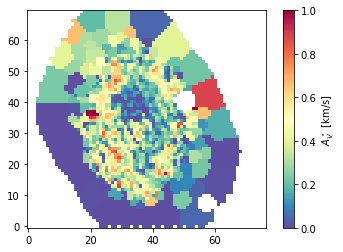

In [13]:
# stellar A_V map
im = plt.imshow(K.A_V__yx, origin='lower', cmap='Spectral_r', vmax=1, vmin=0)
cb = plt.colorbar(im)
cb.ax.set_ylabel(r'$A_V^\star$ [km/s]')

# $\langle\log t_\star\rangle_L$ idade média das populações jovens, intermediarias ou velhas

In [14]:
logt = np.log10(K.ageBase)
selpopY = (logt <= 7.5)
selpopI = (logt > 7.5) & (logt <= 9.5)
selpopO = (logt > 9.5)
popx__tyx = K.popx__tZyx.sum(axis=1)
mean_t_Y__yx = np.tensordot(popx__tyx[selpopY, ...], logt[selpopY], (0, 0))/popx__tyx[selpopY, ...].sum(axis=0)
mean_t_I__yx = np.tensordot(popx__tyx[selpopI, ...], logt[selpopI], (0, 0))/popx__tyx[selpopI, ...].sum(axis=0)
mean_t_O__yx = np.tensordot(popx__tyx[selpopO, ...], logt[selpopO], (0, 0))/popx__tyx[selpopO, ...].sum(axis=0)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide


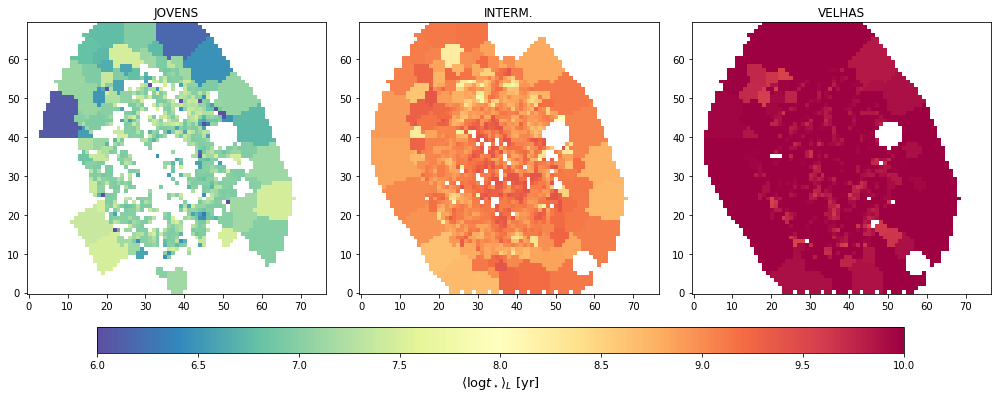

In [17]:
f, axArr = plt.subplots(1, 3, figsize=(14,4.5))
maps = [mean_t_Y__yx, mean_t_I__yx, mean_t_O__yx]
labels = ['JOVENS', 'INTERM.', 'VELHAS']
for i, ax in enumerate(axArr):
    im = ax.imshow(maps[i], origin='lower', cmap='Spectral_r', vmin=6, vmax=10)
    ax.set_title(labels[i])
cbaxes = f.add_axes([0.1, -0.1, 0.8, 0.08])
cb = plt.colorbar(im, cax=cbaxes, orientation='horizontal')
cb.set_label(r'$\langle\log t_\star\rangle_L$ [yr]', fontsize=13) #, color='w', labelpad=-30)
f.tight_layout()